# Project 2: In-Depth Exploratory Data Analysis (EDA)
## Netflix Content Analysis 🎬

**Project Objective:** To perform an in-depth exploratory data analysis of the Netflix dataset. We will explore trends in content production, identify popular genres, analyze content ratings, and understand the distribution of movies and TV shows on the platform. This project builds on foundational EDA by introducing time-series analysis and more complex data cleaning and transformation techniques.

**Class Duration:** 2.5 hours

### Core Concepts We'll Cover:
1.  **Data Cleaning & Transformation:** Handling missing values and converting data types (especially dates).
2.  **Time-Series Analysis:** Analyzing how content has been added to Netflix over the years.
3.  **Text Data Manipulation:** Parsing and analyzing columns with multiple values, like `listed_in` (genres) and `cast`.
4.  **Geographical & Rating Analysis:** Understanding where content comes from and its maturity level.
5.  **Feature Engineering:** Creating new, insightful features like 'content age'.
6.  **Advanced Visualization:** Creating insightful plots to understand distributions and relationships in the data.

### Step 1: Setup - Importing Libraries

As always, we begin by importing our essential data science toolset, including a new library for word clouds.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set a consistent style for our plots
sns.set_style('darkgrid')

### Step 2: Data Loading and Initial Inspection

We'll load the `netflix_titles.csv` dataset and perform a high-level overview.

In [3]:
# !git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

In [4]:
netflix_df = pd.read_csv('../Datasets/netflix_titles.csv')
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [5]:
# Get a concise summary of the dataframe
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


**Interpretation of `.info()`:**
- We have 7787 entries (titles).
- **Key Problem:** The `date_added` column is of type `object` (a string), not a `datetime` object. We cannot perform time-based analysis until this is corrected.
- **Missing Values:** `director`, `cast`, `country`, `date_added`, and `rating` all have missing values. `director` has the most significant number of nulls.

### Step 3: Data Cleaning and Transformation

This step is critical for ensuring our analysis is accurate. We will handle missing values and correct data types.

#### **Theoretical Concept: Data Type Conversion & Handling Nulls**
Data often comes in non-ideal formats. Storing dates as strings, for example, prevents us from extracting components like the year or month, or from plotting data over time. Converting columns to their proper data types (`pd.to_datetime`, `.astype()`) is a fundamental preprocessing step.

For null values, we have several strategies:
1.  **Drop:** If only a very small percentage of rows have missing data, dropping them might be acceptable (`.dropna()`).
2.  **Fill/Impute:** Replace missing values with a placeholder (like "Unknown") or a statistical measure (like the mode for categorical data). This is useful when you don't want to lose the other information in those rows.

In [6]:
# 1. Handle missing values in 'director' and 'cast'
# Since these are text fields and many are missing, we'll fill them with 'Unknown'.
netflix_df['director'] = netflix_df['director'].fillna('Unknown')
netflix_df['cast'] = netflix_df['cast'].fillna('Unknown')

In [7]:
# 2. Handle missing 'country'
# We'll fill with the mode, which is the most common country.
mode_country = netflix_df['country'].mode()[0]
netflix_df['country'] = netflix_df['country'].fillna(mode_country)

In [8]:
# 3. Drop the few rows with missing 'date_added' and 'rating'
# Since the number is small (less than 0.2% of data), dropping them is a safe option.
netflix_df.dropna(subset=['date_added', 'rating'], inplace=True)

In [9]:
# 4. Convert 'date_added' to datetime objects
# Use format='mixed' to handle potential variations in date formats
netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'], format='mixed', dayfirst=False)

* **format='mixed':** This argument tells pandas to infer the date format automatically. This is helpful when the date strings in the column have different formats.

* **dayfirst=False:** This argument specifies that when the date format is ambiguous (e.g., 01/02/2023), it should be interpreted as month first (January 2nd) rather than day first (February 1st).

In [10]:
# 5. Create new features for year and month added
netflix_df['year_added'] = netflix_df['date_added'].dt.year
netflix_df['month_added'] = netflix_df['date_added'].dt.month

In [11]:
# Verify our cleaning and transformation
print("Missing values after cleaning:")
print(netflix_df.isnull().sum())
print("\nData types after transformation:")
print(netflix_df.dtypes)

Missing values after cleaning:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
year_added      0
month_added     0
dtype: int64

Data types after transformation:
show_id                 object
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
description             object
year_added               int32
month_added              int32
dtype: object


### Step 4: Exploratory Data Analysis & Visualization

#### 4.1 What is the distribution of content type?

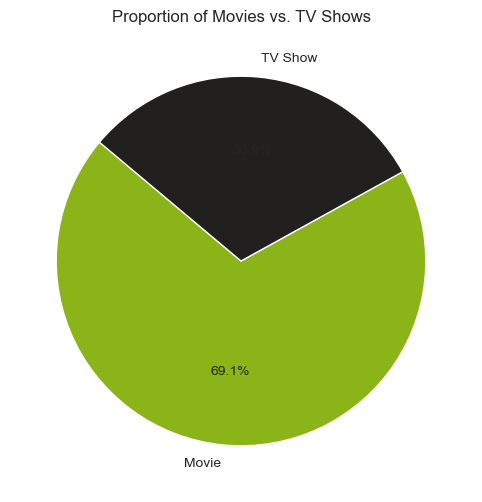

In [12]:
plt.figure(figsize=(8, 6))
type_counts = netflix_df['type'].value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=["#8ab417", '#221f1f'])
plt.title('Proportion of Movies vs. TV Shows')
plt.ylabel('')
plt.show()

**Insight:** The Netflix library is dominated by Movies, which make up roughly 70% of the content in this dataset.

#### 4.2 How has content been added over time?

<Figure size 1400x800 with 0 Axes>

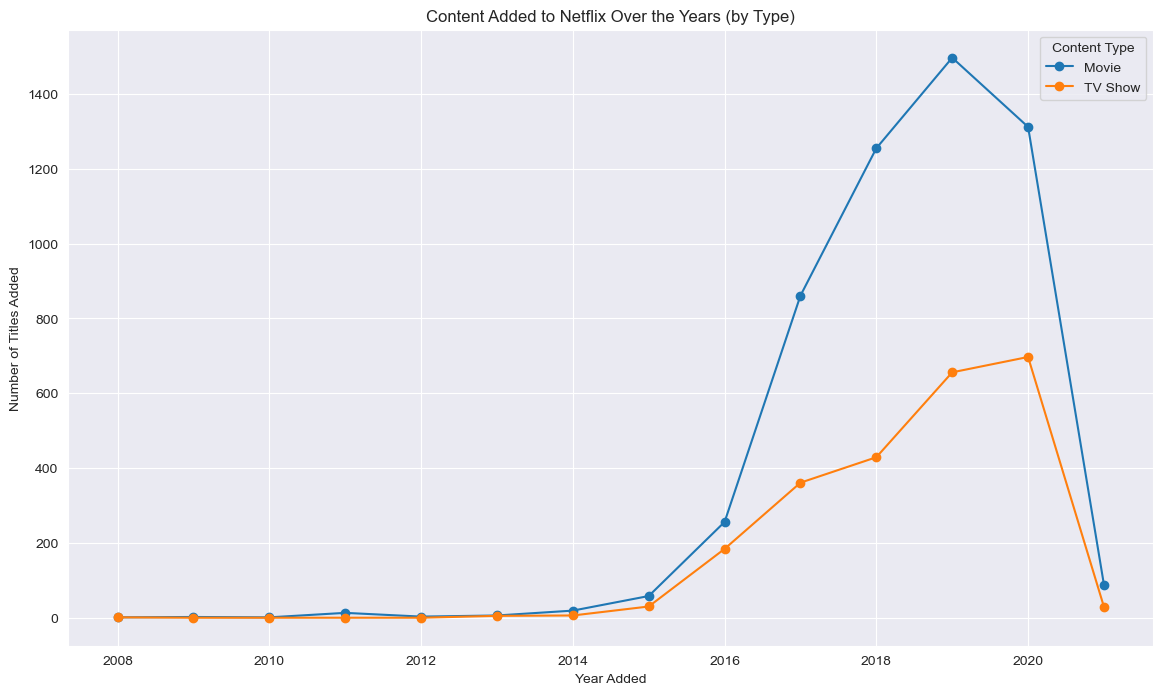

In [13]:
# Group data by year and content type
content_over_time = netflix_df.groupby(['year_added', 'type']).size().unstack().fillna(0)

plt.figure(figsize=(14, 8))
content_over_time.plot(kind='line', marker='o', figsize=(14, 8))
plt.title('Content Added to Netflix Over the Years (by Type)')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles Added')
plt.legend(title='Content Type')
plt.grid(True)
plt.show()

**Insight:** By separating movies and TV shows, we can see that while both grew significantly, the addition of movies accelerated much more dramatically, peaking in 2019. The growth in TV shows has been more steady. There appears to be a slight slowdown in content additions in 2020 and 2021, which could be due to the COVID-19 pandemic affecting productions or the dataset being incomplete for the latest year.

In [14]:
netflix_df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12


#### 4.3 What are the most popular genres?

#### **Theoretical Concept: Handling Multi-Value Text Columns**
The `listed_in` column contains strings with multiple genres separated by commas (e.g., "Dramas, International Movies"). To analyze each genre individually, we need to transform the data. A common technique is to:
1.  **Split** the string in each row into a list of genres.
2.  **Explode** the DataFrame so that each genre in the list gets its own row, duplicating the other information for that title.
This allows us to perform a `value_counts()` on the genres.

In [15]:
# Split the 'listed_in' column and explode it
genres = netflix_df.assign(genre=netflix_df['listed_in'].str.split(', ')).explode('genre')

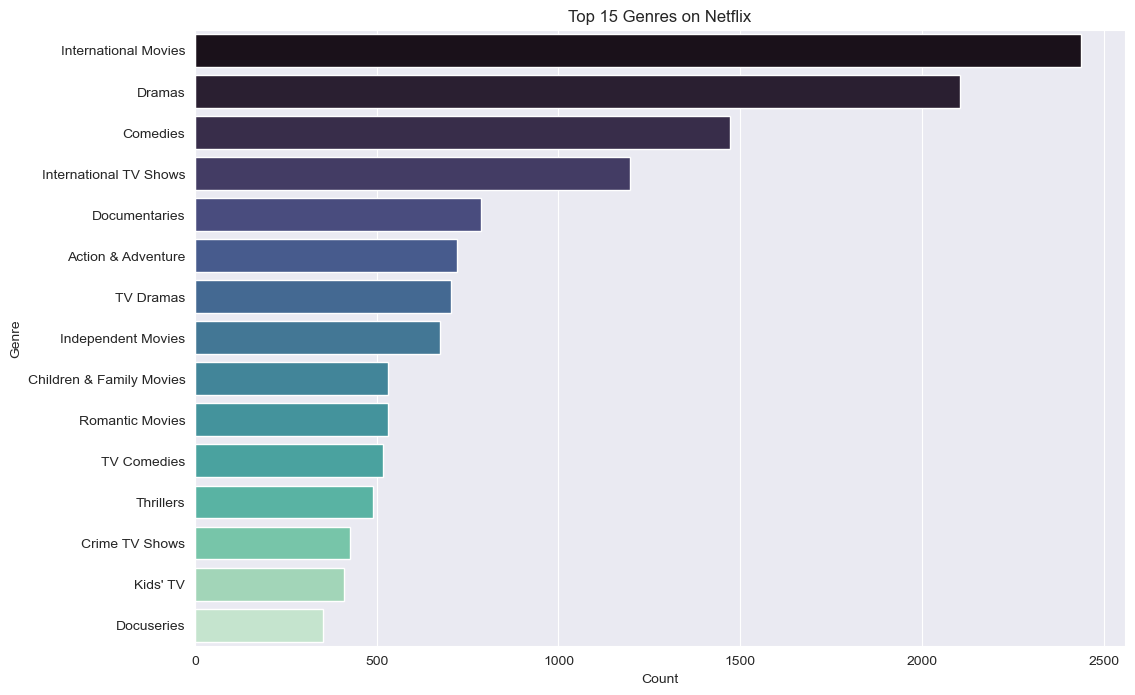

In [16]:
# Get the top 15 genres and their counts
top_genres_counts = genres['genre'].value_counts().reset_index()
top_genres_counts.columns = ['genre', 'count'] # Rename columns for clarity

# Select only the top 15 for plotting
top_genres_counts_plot = top_genres_counts.head(15)

plt.figure(figsize=(12, 8))
sns.barplot(y='genre', x='count', data=top_genres_counts_plot, palette='mako', hue='genre', legend=False)
plt.title('Top 15 Genres on Netflix')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

**Insight:** "International Movies" is the most common genre tag, highlighting Netflix's global content strategy. This is followed by Dramas, Comedies, and Action & Adventure.

#### 4.4 What is the distribution of content duration?

In [17]:
# Separate movies and TV shows
movies_df = netflix_df[netflix_df['type'] == 'Movie'].copy()
tv_shows_df = netflix_df[netflix_df['type'] == 'TV Show'].copy()

In [18]:
# Clean and convert duration for movies
movies_df['duration_min'] = movies_df['duration'].str.replace(' min', '').astype(int)

# Clean and convert duration for TV shows
tv_shows_df['seasons'] = tv_shows_df['duration'].str.replace(' Seasons', '').str.replace(' Season', '').astype(int)

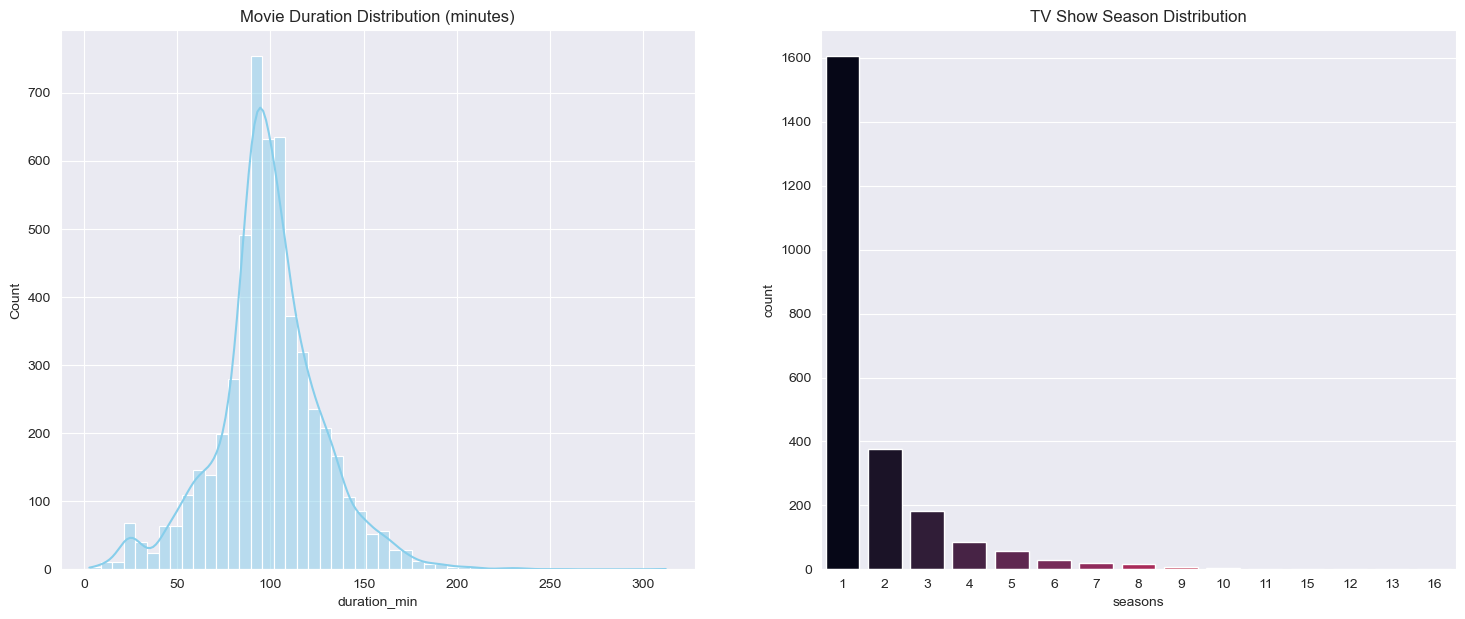

In [19]:
# Plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Movie Duration Distribution
sns.histplot(ax=axes[0], data=movies_df, x='duration_min', bins=50, kde=True, color='skyblue').set_title('Movie Duration Distribution (minutes)')

# TV Show Season Distribution
sns.countplot(ax=axes[1], x='seasons', data=tv_shows_df, palette='rocket', order=tv_shows_df['seasons'].value_counts().index, hue='seasons', legend=False).set_title('TV Show Season Distribution')

plt.show()

**Insight:**
- The majority of movies on Netflix are between 80 and 120 minutes long, which is standard for feature films.
- The vast majority of TV shows on Netflix are short-lived, with most having only 1 season. This could reflect a strategy of producing many pilots and only renewing the most successful ones, or a focus on limited series.

#### 4.5 Where does the content come from? (Geographical Analysis)

In [20]:
# Handle the multi-country listings similar to genres
countries = netflix_df.assign(country=netflix_df['country'].str.split(', ')).explode('country')

In [21]:
# Get the top 15 countries and their counts
top_countries_counts = countries['country'].value_counts().reset_index()
top_countries_counts.columns = ['country', 'count'] # Rename columns for clarity

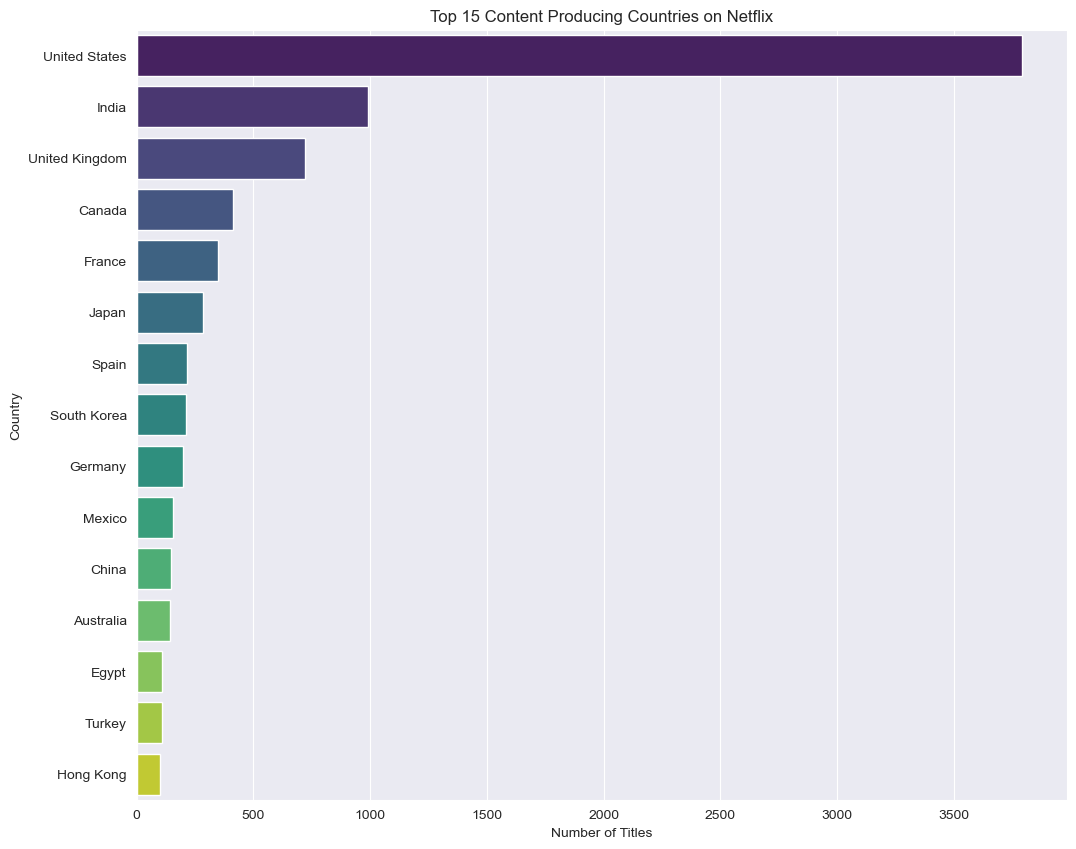

In [22]:
# Select only the top 15 for plotting
top_countries_counts_plot = top_countries_counts.head(15)

plt.figure(figsize=(12, 10))
sns.barplot(y='country', x='count', data=top_countries_counts_plot, palette='viridis', hue='country', legend=False)
plt.title('Top 15 Content Producing Countries on Netflix')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.show()

**Insight:** The United States is by far the largest producer of content available on Netflix. However, India is a very strong second, which explains why so many of the top actors were from India. The UK, Japan, and South Korea also represent major content markets for the platform, emphasizing its global nature.

In [23]:
netflix_df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12


#### 4.6 What are the maturity ratings of the content?

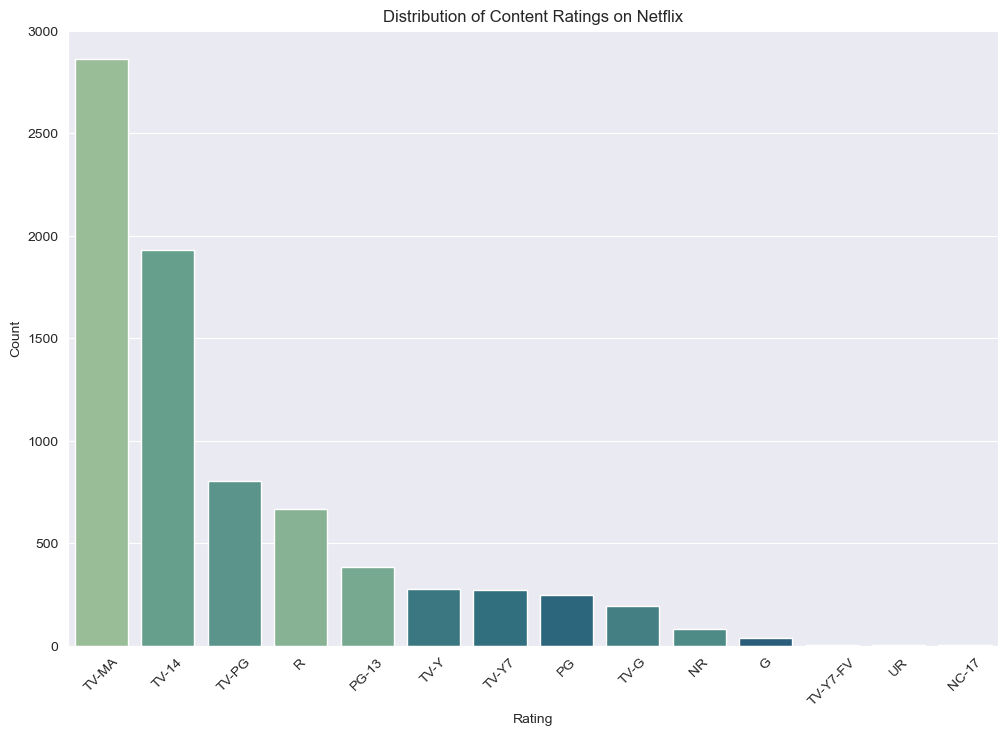

In [24]:
plt.figure(figsize=(12, 8))
sns.countplot(x='rating', data=netflix_df, order=netflix_df['rating'].value_counts().index, palette='crest', hue='rating', legend=False)
plt.title('Distribution of Content Ratings on Netflix')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

**Insight:** A large portion of Netflix's content is aimed at mature audiences, with `TV-MA` (Mature Audience) and `TV-14` (Parents Strongly Cautioned) being the two most common ratings. This suggests a focus on adult viewers over content for children (`TV-G`, `TV-Y`).

### Step 5: Feature Engineering - Content Freshness
Let's create a new feature to analyze how old content is when it gets added to Netflix. This can tell us about their acquisition strategy (buying old classics vs. releasing new originals).

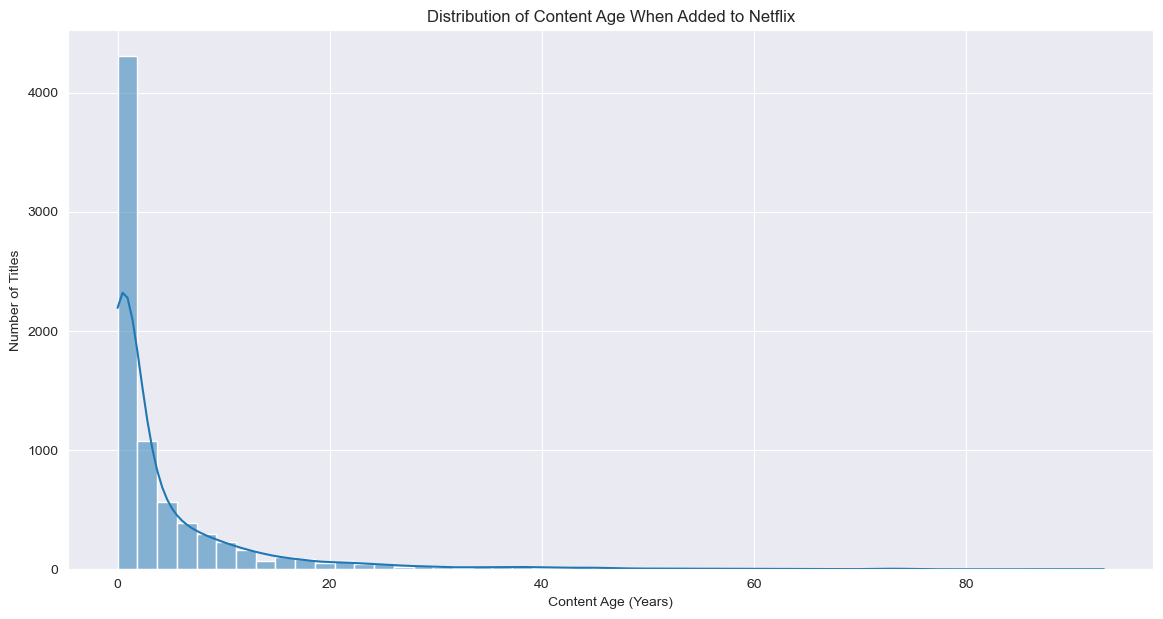

In [25]:
# Create the 'age_on_netflix' feature
netflix_df['age_on_netflix'] = netflix_df['year_added'] - netflix_df['release_year']

# Filter out any potential errors where added_year is before release_year
content_age = netflix_df[netflix_df['age_on_netflix'] >= 0]

plt.figure(figsize=(14, 7))
sns.histplot(data=content_age, x='age_on_netflix', bins=50, kde=True)
plt.title('Distribution of Content Age When Added to Netflix')
plt.xlabel('Content Age (Years)')
plt.ylabel('Number of Titles')
plt.show()

**Insight:** The large spike at `0` indicates that a significant amount of content is added in the same year it's released, which is characteristic of "Netflix Originals." However, there is a very long tail, showing that Netflix also heavily invests in acquiring licensed content that can be decades old, building a deep library of classic films and shows.

### Step 6: Deeper Multivariate Analysis

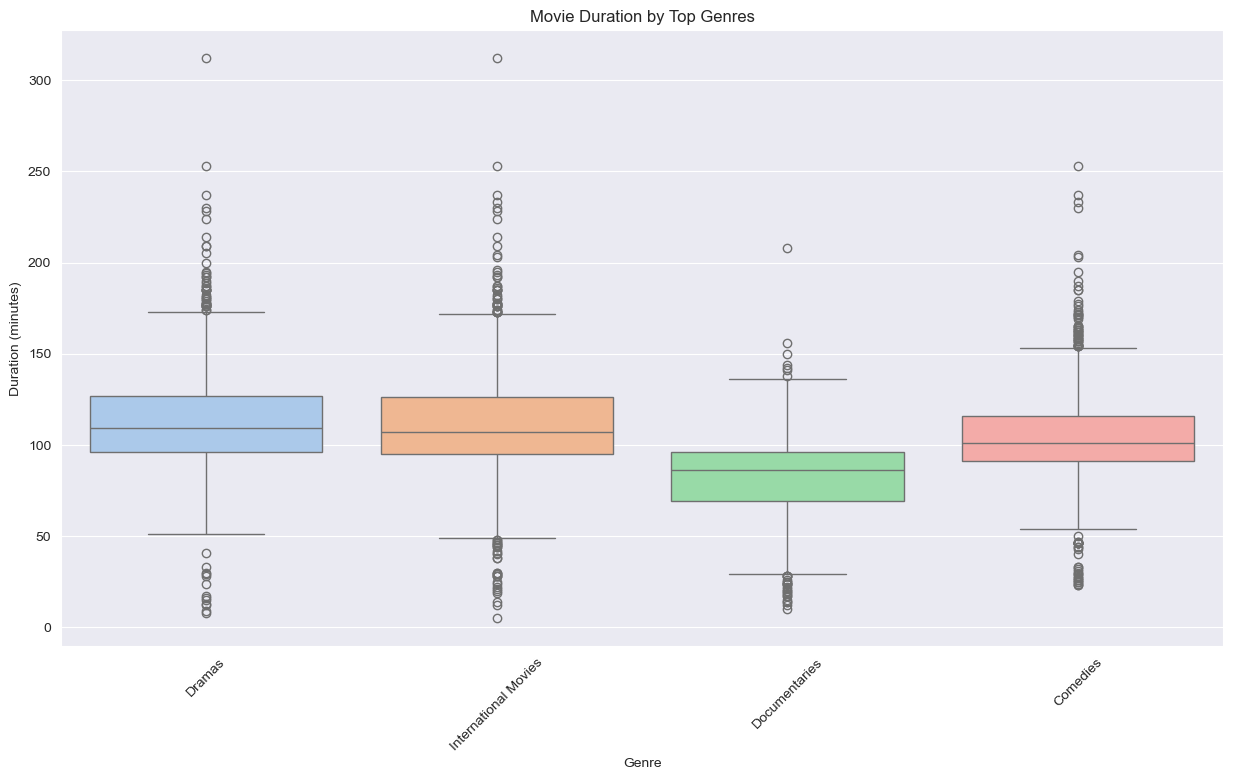

In [26]:
# Analyze movie duration across different top genres
top_genres = genres['genre'].value_counts().index[:5]
genres_movies = genres[(genres['type'] == 'Movie') & (genres['genre'].isin(top_genres))].copy()
genres_movies['duration_min'] = genres_movies['duration'].str.replace(' min', '').astype(int)

plt.figure(figsize=(15, 8))
sns.boxplot(data=genres_movies, x='genre', y='duration_min', palette='pastel', hue='genre', legend=False)
plt.title('Movie Duration by Top Genres')
plt.xlabel('Genre')
plt.ylabel('Duration (minutes)')
plt.xticks(rotation=45)
plt.show()

**Insight:** While the median duration for most top genres is similar (around 90-100 minutes), we can see some interesting variations. For example, Dramas tend to have a wider range of durations, with many longer films. International Movies also show a broad distribution, reflecting diverse filmmaking styles from around the world.

### Step 7: Word Cloud from Content Descriptions
As a final visual analysis, let's generate a word cloud from the `description` column to see what themes and words are most common in Netflix content.

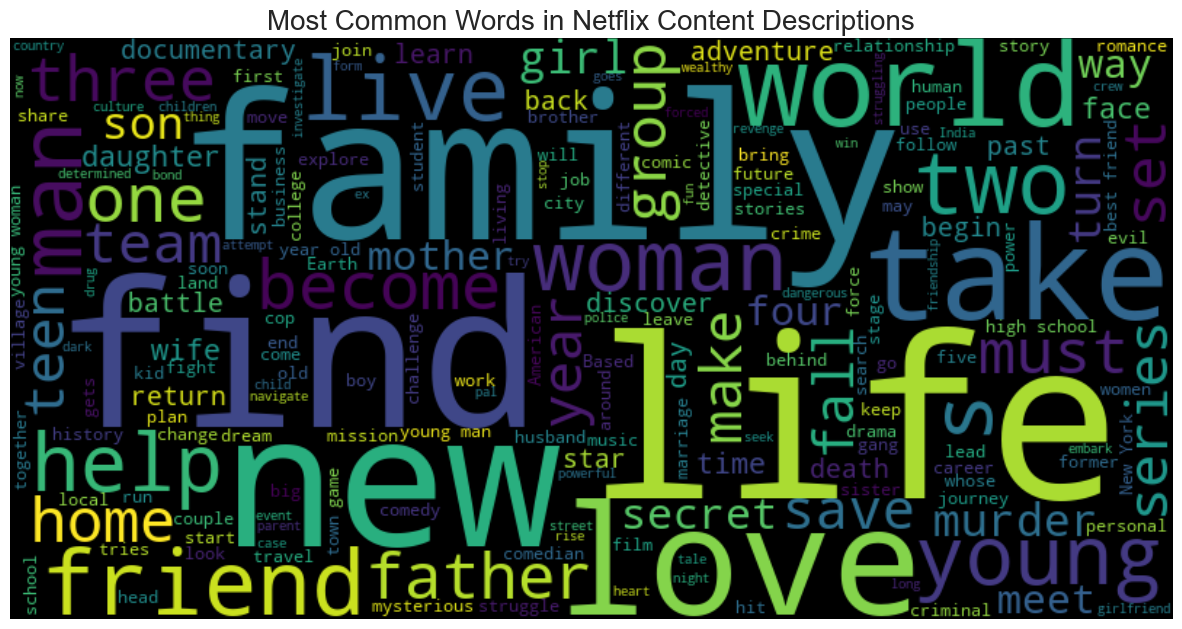

In [27]:
# Combine all descriptions into a single string
text = ' '.join(netflix_df['description'])

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

# Display the generated image
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Netflix Content Descriptions', fontsize=20)
plt.show()

**Insight:** The word cloud highlights common themes and subjects. Words like "life," "family," "love," "young," "friends," and "world" are prominent, suggesting that much of the content revolves around human relationships and personal journeys. Action-oriented words like "find," "secret," and "new" also appear frequently.

### Step 8: Final Conclusion and Summary of Insights

This in-depth EDA of the Netflix dataset has revealed several key characteristics and strategies of the platform's content library.

**Key Findings:**
1. **Content Strategy:** Netflix's library is movie-heavy (~70%), and the platform aggressively added content between 2016-2019. Their strategy involves a mix of brand new originals (added the same year they are released) and a deep library of licensed older content.
2. **Global Dominance:** While the US is the top content producer, the platform is heavily international, with India being a massive contributor. This is reflected in the top genres ("International Movies") and most frequent actors.
3. **Target Audience:** The content library is skewed towards mature audiences, with `TV-MA` and `TV-14` being the most common ratings.
4. **Content Format & Genre:** Dramas and Comedies are universally popular genres. Most movies stick to a standard 90-120 minute runtime, while the vast majority of TV shows only last for a single season, suggesting a high-risk, high-reward approach to series production.
5. **Common Themes:** Descriptions of content frequently revolve around universal themes of life, family, love, and discovery.

**Limitations:** This dataset is a snapshot in time and lacks viewership data. Therefore, our analysis is of the *supply* of content, not its *demand* or popularity. Nonetheless, this EDA provides a strong, multi-faceted understanding of the composition and evolution of the Netflix library.

# Submission Q's

* How has the distribution of content ratings changed over time?
* Is there a relationship between content age and its type (Movie vs. TV Show)?
* Can we identify any trends in content production based on the release year vs. the year added to Netflix?
* What are the most common word pairs or phrases in content descriptions?
* Who are the top directors on Netflix?

In [28]:
from copy import deepcopy
df = deepcopy(netflix_df)

In [85]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,age_on_netflix
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8,0
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12,0
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018,12,7
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017,11,8
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020,1,12


## Submission - Q1

year_added,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
rating,,,,,,,,,,,,,,
G,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,4.0,12.0,8.0,10.0,1.0
NC-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
NR,0.0,0.0,1.0,0.0,0.0,4.0,0.0,5.0,28.0,26.0,14.0,5.0,0.0,0.0
PG,0.0,0.0,0.0,0.0,1.0,1.0,3.0,2.0,3.0,20.0,34.0,85.0,89.0,9.0
PG-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,26.0,55.0,146.0,132.0,19.0
R,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,14.0,66.0,131.0,226.0,199.0,25.0
TV-14,0.0,0.0,0.0,5.0,0.0,2.0,2.0,15.0,103.0,339.0,458.0,519.0,464.0,21.0
TV-G,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,9.0,23.0,37.0,41.0,68.0,6.0
TV-MA,2.0,2.0,0.0,3.0,0.0,3.0,12.0,29.0,163.0,455.0,661.0,793.0,712.0,26.0


<Figure size 1600x800 with 0 Axes>

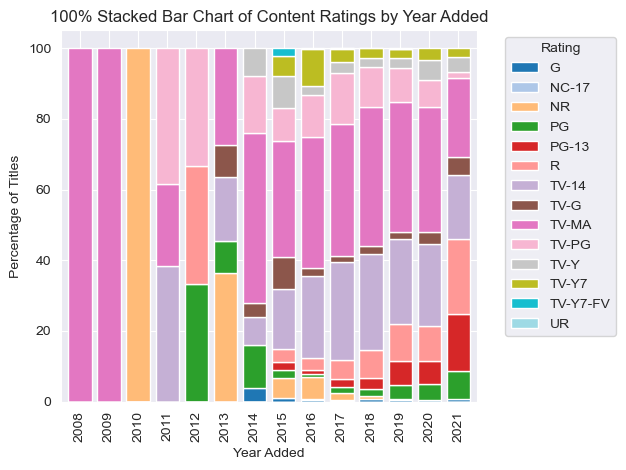

In [40]:
rating_year = df.groupby(['rating','year_added']).size().unstack().fillna(0)
display(rating_year)
rating_year_pct = rating_year.div(rating_year.sum(axis=0), axis=1) * 100

plt.figure(figsize=(16, 8))
rating_year_pct.T.plot(kind='bar', stacked=True, colormap='tab20', width=0.8)
plt.title('100% Stacked Bar Chart of Content Ratings by Year Added')
plt.xlabel('Year Added')
plt.ylabel('Percentage of Titles')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Submission Q2

In [69]:
desc_movie = df[df['type'] == 'Movie']['age_on_netflix'].describe(percentiles=[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]).to_frame().T
desc_movie.index = ['Movie']

desc_tv = df[df['type'] == 'TV Show']['age_on_netflix'].describe(percentiles=[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]).to_frame().T
desc_tv.index = ['TV']

summary_compare = pd.concat([desc_movie, desc_tv])
summary_compare


,count,mean,std,min,0%,1%,5%,10%,25%,50%,75%,90%,95%,99%,100%,max
Movie,5372.0,5.563291,9.728080,-1.0,-1.0,0.0,0.0,0.0,0.0,1.0,7.0,16.0,25.0,47.00,75.0,75.0
TV,2398.0,2.311093,5.281635,-3.0,-3.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,10.0,24.03,93.0,93.0


#### /* Many older movies are available where as TV shows are much more recent */

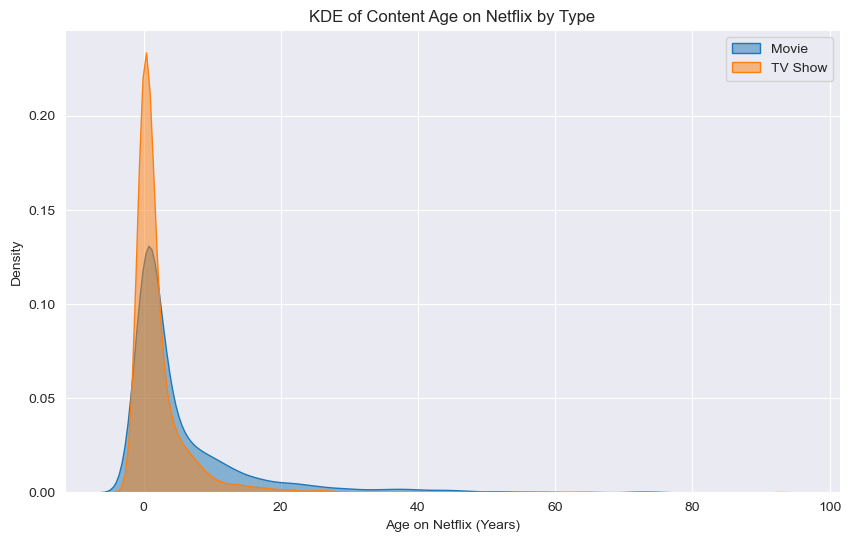

In [71]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df['type'] == 'Movie'], x='age_on_netflix', label='Movie', fill=True, alpha=0.5)
sns.kdeplot(data=df[df['type'] == 'TV Show'], x='age_on_netflix', label='TV Show', fill=True, alpha=0.5)
plt.title('KDE of Content Age on Netflix by Type')
plt.xlabel('Age on Netflix (Years)')
plt.ylabel('Density')
plt.legend()
plt.show()

## Submission Q3

In [79]:
trend_pivot = df.groupby(['release_year', 'year_added']).size().unstack().fillna(0)
trend_pivot

year_added,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
release_year,,,,,,,,,,,,,,
1925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
1944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
1945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,386.0,347.0,178.0,95.0,3.0
2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,572.0,399.0,145.0,2.0
2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,709.0,279.0,5.0


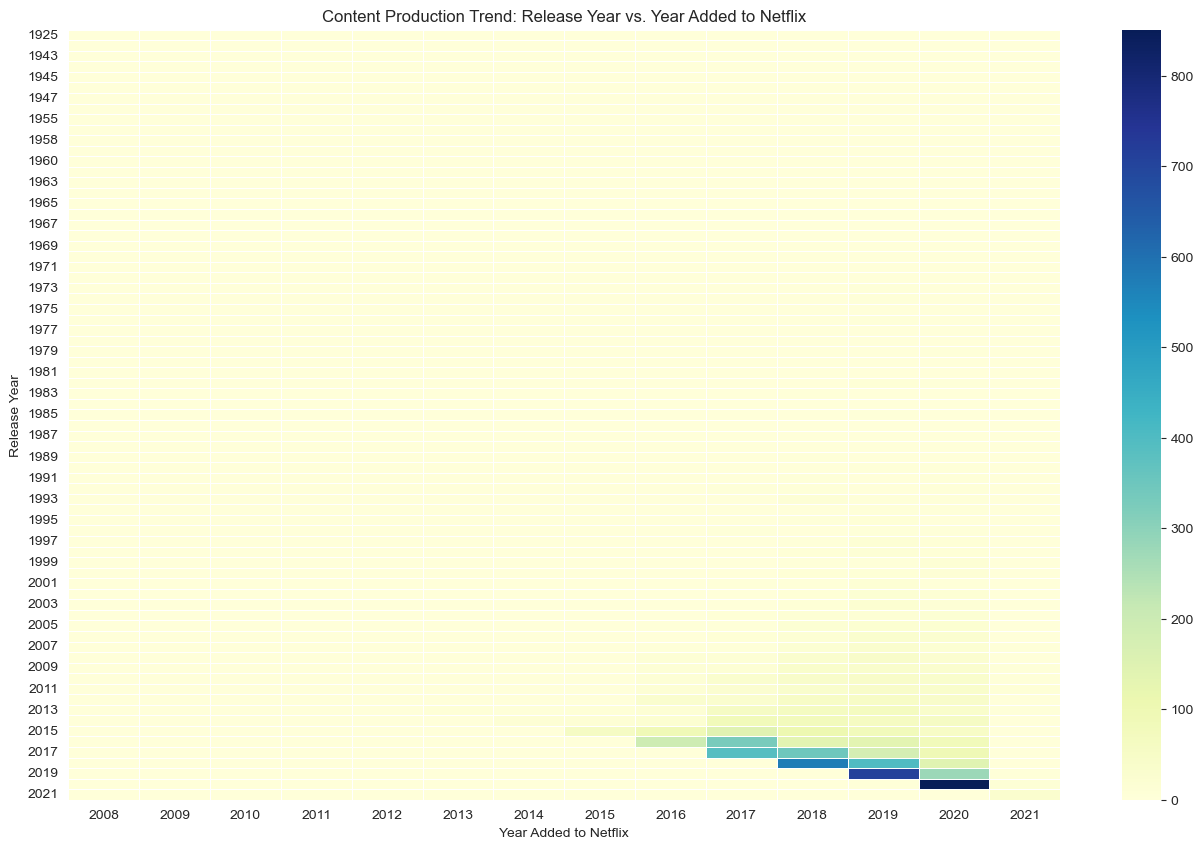

In [ ]:
plt.figure(figsize=(16, 10))
sns.heatmap(trend_pivot, cmap='YlGnBu', linewidths=0.5)
plt.title('Content Production Trend: Release Year vs. Year Added to Netflix')
plt.xlabel('Year Added to Netflix')
plt.ylabel('Release Year')
plt.show()

* Above chart shows us the content production volume trend in 2-dimension : Release Year vs Year Added on Netflix. From the heatmap we can show the significant volumnes are coming in the recent years.

## Submission Q4

In [90]:
from wordcloud import STOPWORDS

In [94]:
pair_counts

{('future', 'elite'): 1,
 ('elite', 'inhabit'): 1,
 ('inhabit', 'island'): 1,
 ('island', 'paradise'): 1,
 ('paradise', 'far'): 1,
 ('far', 'crowded'): 1,
 ('crowded', 'slums,'): 1,
 ('slums,', 'one'): 1,
 ('one', 'chance'): 6,
 ('chance', 'join'): 1,
 ('join', '3%'): 1,
 ('3%', 'saved'): 1,
 ('saved', 'squalor.after'): 1,
 ('squalor.after', 'devastating'): 1,
 ('devastating', 'earthquake'): 1,
 ('earthquake', 'hits'): 3,
 ('hits', 'mexico'): 1,
 ('mexico', 'city,'): 5,
 ('city,', 'trapped'): 1,
 ('trapped', 'survivors'): 1,
 ('survivors', 'walks'): 1,
 ('walks', 'life'): 6,
 ('life', 'wait'): 1,
 ('wait', 'rescued'): 1,
 ('rescued', 'trying'): 1,
 ('trying', 'desperately'): 1,
 ('desperately', 'stay'): 1,
 ('stay', 'alive.when'): 1,
 ('alive.when', 'army'): 1,
 ('army', 'recruit'): 3,
 ('recruit', 'found'): 1,
 ('found', 'dead,'): 2,
 ('dead,', 'fellow'): 1,
 ('fellow', 'soldiers'): 1,
 ('soldiers', 'forced'): 1,
 ('forced', 'confront'): 2,
 ('confront', 'terrifying'): 1,
 ('terrifyin

In [ ]:
text = ''.join(df.description)
text = text.lower()
stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)
words = [word for word in text.split()]
pairs = [(words[i],words[i+1]) for i in range(len(words)-1)]
pair_counts = {}
for pair in pairs:
    pair_counts[pair]= pair_counts.get(pair,0) + 1
sorted_pairs = sorted(pair_counts.items(),key = lambda x: x[1], reverse=True)
for pair, count in sorted_pairs[:10]:
    print(f"{pair}: {count}")

('high', 'school'): 99
('young', 'man'): 98
('young', 'woman'): 84
('new', 'york'): 59
('world', 'war'): 43
('documentary', 'follows'): 38
('best', 'friends'): 38
('based', 'true'): 37
('falls', 'love'): 32
('documentary', 'series'): 26


## Submission Q5

In [102]:
df.director.value_counts()

director
Unknown                   2376
Raúl Campos, Jan Suter      18
Marcus Raboy                16
Jay Karas                   14
Cathy Garcia-Molina         13
                          ... 
Diego Enrique Osorno         1
Nottapon Boonprakob          1
John Suits                   1
Ryan Koo                     1
Paul Greengrass              1
Name: count, Length: 4048, dtype: int64

In [109]:
director_counts = df['director'].value_counts().reset_index()
director_counts

top_3_directors = director_counts[director_counts['director'] != 'Unknown'].head(3)
list1 = list(top_3_directors['director'])
print(list1)

['Raúl Campos, Jan Suter', 'Marcus Raboy', 'Jay Karas']


### You can connect with me on [Linkedin](https://www.linkedin.com/in/harshvardhan-singh-350262178/) if you like the content